# Análise de fraudes de clonagem de cartão

Ricardo G. Herrmann < <ricardo.herrmann@emc.com> >

*Agosto de 2016*

## Entendimento do negócio

O fraudador utiliza um dispositivo para clonar cartões, instalando-o em pontos de estabelecimentos. O uso deste dispositivo varia ao longo do tempo, onde um fraudador pode instalar e desinstalar o dispositivo em locais e horários que sejam convenientes para a clonagem. O fraudador não faz uma instalação definitiva do dispositivo, para reduzir o risco de descoberta.

Uma vez que o fraudador acumule uma quantidade significativa de cartões, este tenta utilizá-los, geralmente fazendo compras (na maioria daz vezes, *online*, para reduzir o risco) ou entrando em contato com o atendimento (para obter mais dados).

### Objetivo de negócio

Nesta análise, nosso foco é cobrir o caso de compras contestadas. Nem sempre a compra utilizando o cartão clonado procede normalmente, devido ao sistema de anti-fraudes, e então o fraudador tenta realizar a mesma compra em sequência, com vários cartões, até que algum funcione, ou então pode acabar efetuando várias compras no mesmo lote.

### Plano do projeto

A estratégia de análise, em alto nível, é rastrear, a partir das compras contestadas, onde no espaço e tempo pode ter ocorrido a clonagem dos cartões envolvidos na fraude, e a partir daí estabelecer um perfil que indique as características principais que sejam atrativas para a aplicação da fraude.

## Preparativos da programação

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

## Entendimento dos dados

Existem duas massas de dados disponíveis: a de compras contestadas e a base de contestações.

### Descrição dos dados iniciais

Compras contestadas no cartão de crédito

In [1]:
contestadas_df = sqlContext.read.parquet("hdfs:/user/x181471/cache/transacoes/credito/final/contestadas")

In [2]:
contestadas_df.printSchema()

root
 |-- idSia: string (nullable = true)
 |-- cartao: string (nullable = true)
 |-- dataHoraAutorizacao: timestamp (nullable = true)
 |-- idEstabelecimento: string (nullable = true)
 |-- nomeEstabelecimento: string (nullable = true)
 |-- ramoEstabelecimentoId: long (nullable = true)
 |-- ramoEstabelecimentoNome: string (nullable = true)
 |-- modoEntradaId: string (nullable = true)
 |-- modoEntradaNome: string (nullable = true)
 |-- pais: long (nullable = true)
 |-- tipoLancamento: long (nullable = true)
 |-- flagContestacao: boolean (nullable = true)
 |-- valor: double (nullable = true)
 |-- contcur: timestamp (nullable = true)
 |-- observacoes: string (nullable = true)



In [ ]:
contestadas_df.describe().toPandas()

Contestações antes do join

In [ ]:
dfContestacoesAntesDoJoin = sqlContext.read.parquet("hdfs:/user/x181471/cache/contestacoes/credito/final")

# Notebook original

**Verificar se existem contestações que não encontramos a autorização correspondente:**

É preciso comparar o número de transações com idSia distintos encontrados antes e depois do join com a MPDT004 (Autorizações):

In [5]:
dfContestacoes.select('idSia').distinct().count()

482308

In [6]:
dfContestacoesAntesDoJoin = sqlContext.read.parquet("hdfs:/user/x181471/cache/contestacoes/credito/final")

In [79]:
dfContestacoesAntesDoJoin.filter('flagContestacao = true').select('idSia').distinct().count()

1168451

##### Realizando os principais imports

In [6]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import abs, ceil, when, mean, min, max, desc, to_date, col, year, from_unixtime, unix_timestamp, dayofmonth

##### Verificando a estatística básica do dado:

In [5]:
dfContestacoes.describe().show()

+-------+---------------------+------------------+-----------------+-----------------+
|summary|ramoEstabelecimentoId|              pais|   tipoLancamento|            valor|
+-------+---------------------+------------------+-----------------+-----------------+
|  count|               483122|            483122|           483122|           483122|
|   mean|     5679.11442037415|193.75455475014593|6089.014938255761|287.6288629373119|
| stddev|    1092.428475508439|263.97699414700446|39.01450611802863|1191.076364334397|
|    min|                  742|                 8|             6000|              0.0|
|    max|                 9405|               862|             6521|        306800.52|
+-------+---------------------+------------------+-----------------+-----------------+



In [6]:
dfContestacoes.show(5,False)

+----------------+----------------+---------------------+-----------------+-------------------+---------------------+-----------------------+-------------+---------------+----+--------------+---------------+------+---------------------+-----------+
|idSia           |cartao          |dataHoraAutorizacao  |idEstabelecimento|nomeEstabelecimento|ramoEstabelecimentoId|ramoEstabelecimentoNome|modoEntradaId|modoEntradaNome|pais|tipoLancamento|flagContestacao|valor |contcur              |observacoes|
+----------------+----------------+---------------------+-----------------+-------------------+---------------------+-----------------------+-------------+---------------+----+--------------+---------------+------+---------------------+-----------+
|2015043835408501|5447317322072677|2016-01-05 12:08:47.0|020541821        |CADASTRO VIVO      |5045                 |ARTIGOS ELETRÔNICOS    |01           |Digitada       |76  |6100          |true           |8.0   |2016-01-06 23:09:15.0|           |
|201

Verificando a data minima e máxima dos dados de contestação:

In [7]:
dfContestacoes.select([min('dataHoraAutorizacao'),max('dataHoraAutorizacao'),mean('valor'),min('valor'), max('valor')]).show(25,False)

+------------------------+------------------------+-----------------+----------+----------+
|min(dataHoraAutorizacao)|max(dataHoraAutorizacao)|avg(valor)       |min(valor)|max(valor)|
+------------------------+------------------------+-----------------+----------+----------+
|2011-02-13 11:56:04.0   |2016-05-11 04:17:24.0   |287.6288629373119|0.0       |306800.52 |
+------------------------+------------------------+-----------------+----------+----------+



In [8]:
dfContestacoes.show

<bound method DataFrame.show of DataFrame[idSia: string, cartao: string, dataHoraAutorizacao: timestamp, idEstabelecimento: string, nomeEstabelecimento: string, ramoEstabelecimentoId: bigint, ramoEstabelecimentoNome: string, modoEntradaId: string, modoEntradaNome: string, pais: bigint, tipoLancamento: bigint, flagContestacao: boolean, valor: double, contcur: timestamp, observacoes: string]>

## Avaliando a distribuição de contestações pelo modo entrada e país

Preperando os dados para os gráficos com novas colunas

In [7]:
dfContestacoesModoEntrada = dfContestacoes.withColumn('usoPresente',
                                                      when(dfContestacoes.modoEntradaNome == "Tarja","Presente").
                                                      when(dfContestacoes.modoEntradaNome == "Chip","Presente").
                                                      otherwise("Não Presente"))

Analisando o ramo do estabelecimento vs o tipo de uso (Presente x Não Presente):

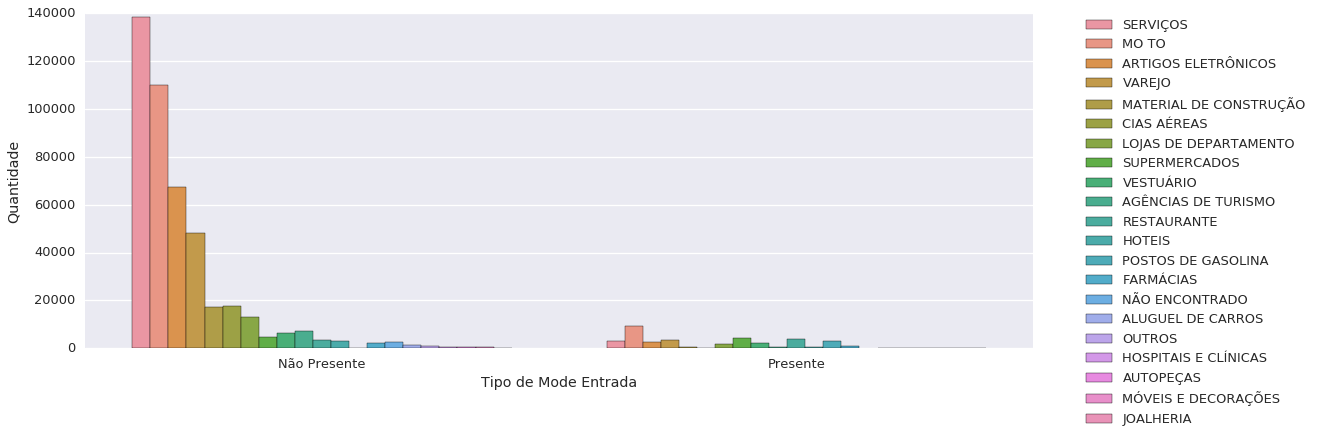

In [11]:
from pyspark.sql.functions import desc
sns.set_context("talk")
plt.figure(figsize=(17, 6))

contestacoesPorRamoEUsoPandas = dfContestacoesModoEntrada.cube("ramoEstabelecimentoNome", "usoPresente").count().orderBy("usoPresente",desc("count")).toPandas()
g = sns.barplot(x="usoPresente", y="count", hue="ramoEstabelecimentoNome", data=contestacoesPorRamoEUsoPandas)
g.set(xlabel='Tipo de Mode Entrada', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

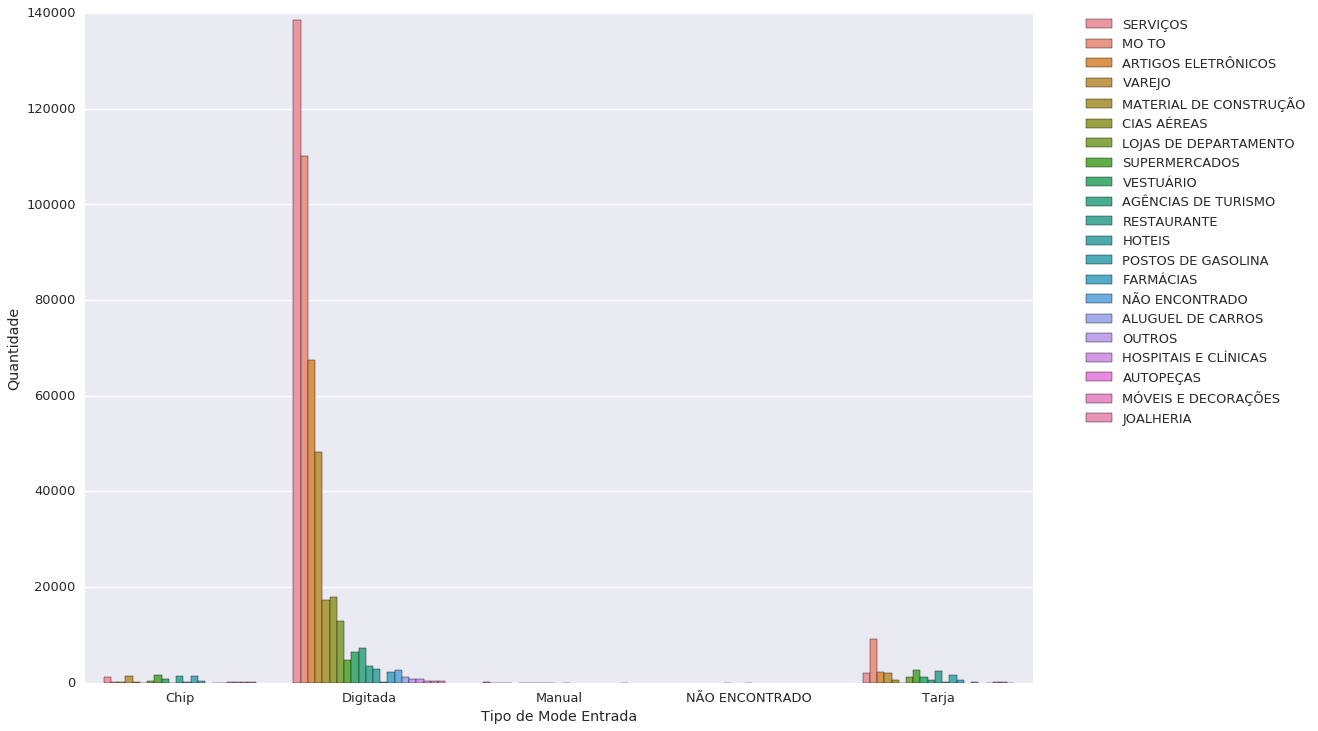

In [12]:
sns.set_context("talk")
plt.figure(figsize=(17, 12))
contestacoesPorRamoEModoEntradaPandas = dfContestacoesModoEntrada.cube("ramoEstabelecimentoNome",
                                                                       "modoEntradaNome").count().orderBy("modoEntradaNome",desc("count")).toPandas()
g = sns.barplot(x="modoEntradaNome", y="count", hue="ramoEstabelecimentoNome", data=contestacoesPorRamoEModoEntradaPandas)
g.set(xlabel='Tipo de Mode Entrada', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Quais são os países que temos mais problemas com o uso presente (Tarja/Chip)?

In [13]:
from pyspark.sql.functions import desc
dfContestacoesPorPaisEUso = dfContestacoesModoEntrada.filter("usoPresente = 'Presente'").withColumn('pais',
                                                      when(dfContestacoes.pais == 32,"Argentina").
                                                      when(dfContestacoes.pais == 76,"Brasil").
                                                      when(dfContestacoes.pais == 250,"França").
                                                      when(dfContestacoes.pais == 600,"Paraguai").
                                                      when(dfContestacoes.pais == 604,"Peru").
                                                      when(dfContestacoes.pais == 840,"USA").
                                                      when(dfContestacoes.pais == 826,"Inglaterra").
                                                      otherwise("Outros"))
dfContestacoesPorPaisEUsoPandas = dfContestacoesPorPaisEUso.cube("pais", "modoEntradaNome").count().orderBy(desc("count")).toPandas().head(20)
sns.set_context("talk")
plt.figure(figsize=(17, 12))
g = sns.barplot(x="modoEntradaNome", y="count", hue="pais", data=dfContestacoesPorPaisEUsoPandas)
g.set(xlabel='Tipo de Mode Entrada (e Pais)', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avaliando tendencias de contestações ao longo do tempo

Vamos avaliar a quantidade de contestações ao longo do tempo para identificar tendencias. Vamos considerar a quantidade ao invés do valor pois:
* Valores mudam ao longo do tempo conforme a tendencia inflacionária
* Valores mudam variam ao longo do tempo por conta da oscilação da moeda

Quantidade de contestações ao longo do tempo:

Preparando a data para manipulação:

Contestações ao longo do tempo:

In [8]:
dfContestacoesDataFull = dfContestacoesModoEntrada.withColumn('dataAutorizacao',to_date(dfContestacoesModoEntrada.dataHoraAutorizacao))
#dfCountContestacoesDatapandas = dfContestacoesData.toPandas()

In [9]:
dfContestacoesDataFull.show(5,False)

+----------------+----------------+---------------------+-----------------+-------------------+---------------------+-----------------------+-------------+---------------+----+--------------+---------------+------+---------------------+-----------+------------+---------------+
|idSia           |cartao          |dataHoraAutorizacao  |idEstabelecimento|nomeEstabelecimento|ramoEstabelecimentoId|ramoEstabelecimentoNome|modoEntradaId|modoEntradaNome|pais|tipoLancamento|flagContestacao|valor |contcur              |observacoes|usoPresente |dataAutorizacao|
+----------------+----------------+---------------------+-----------------+-------------------+---------------------+-----------------------+-------------+---------------+----+--------------+---------------+------+---------------------+-----------+------------+---------------+
|2015043835408501|5447317322072677|2016-01-05 12:08:47.0|020541821        |CADASTRO VIVO      |5045                 |ARTIGOS ELETRÔNICOS    |01           |Digitada   

In [10]:
dfCountContestacoesPorDiaFullPandas = dfContestacoesDataFull.groupBy('dataAutorizacao').count().select(col('dataAutorizacao'),
                                                                                                       col('count').alias('qtde')).toPandas()

In [11]:
dfCountContestacoesPorDiaFullPandas.sort_values(by='dataAutorizacao').set_index('dataAutorizacao').plot(figsize=(20,10))

# Plota com o std
#sns.plot(data=dfCountContestacoesPorDiaPandas)

Aparentemente, somente temos registros importantes de constestações a entre **outubro-2015 e março de-2016 (6 meses).**:

Realiza as seguintes operações para análise de variâncias:
* Adiciona a informação do dia da semana
* Adiciona a informação da semana do mês

In [12]:
#dfContestacoesData = dfContestacoesDataFull.withColumn('ano',year('dataAutorizacao')).filter('ano > 2014').cache()
dfContestacoesData = dfContestacoesDataFull.filter(
    col("dataAutorizacao").between("2015-10-01","2016-04-01")).withColumn("DiaDaSemana",
    from_unixtime(unix_timestamp(col("dataAutorizacao"),"yyyy-MM-dd"),"EEEEE")).withColumn("SemanaDoMes",
    ceil(dayofmonth(col("dataAutorizacao")) / 7)).cache()
dfCountContestacoesPorDiaPandas = dfContestacoesData.groupBy('dataAutorizacao','DiaDaSemana','SemanaDoMes').count().select(col('dataAutorizacao'),
                                    col('DiaDaSemana'),col('SemanaDoMes'),col('count').alias('qtde')).toPandas()

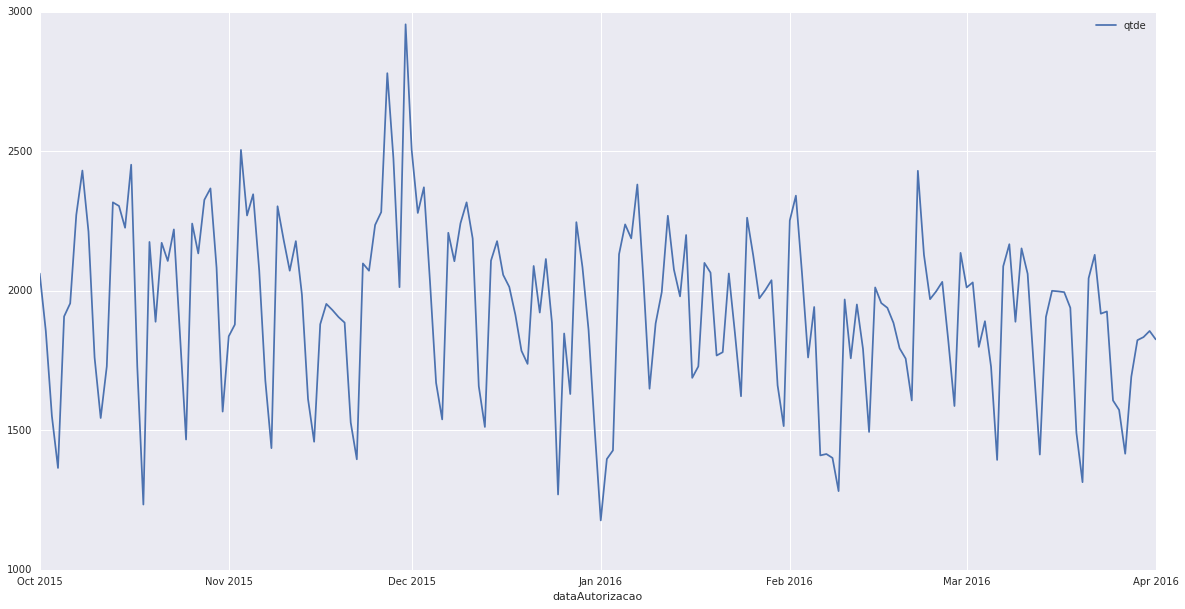

In [13]:
dfCountContestacoesPorDiaPandas[["dataAutorizacao","qtde"]].sort_values(by='dataAutorizacao').set_index('dataAutorizacao').plot(figsize=(20,10))

**Verificando a variância por dia da semana:**

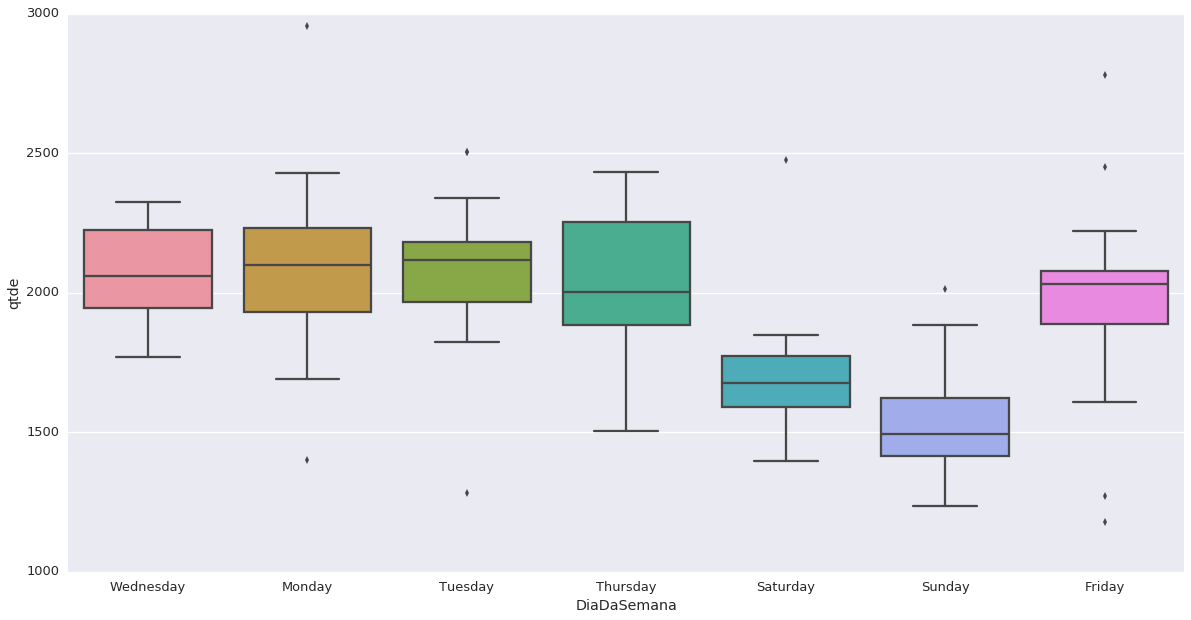

In [87]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="DiaDaSemana", y="qtde", data=dfCountContestacoesPorDiaPandas)

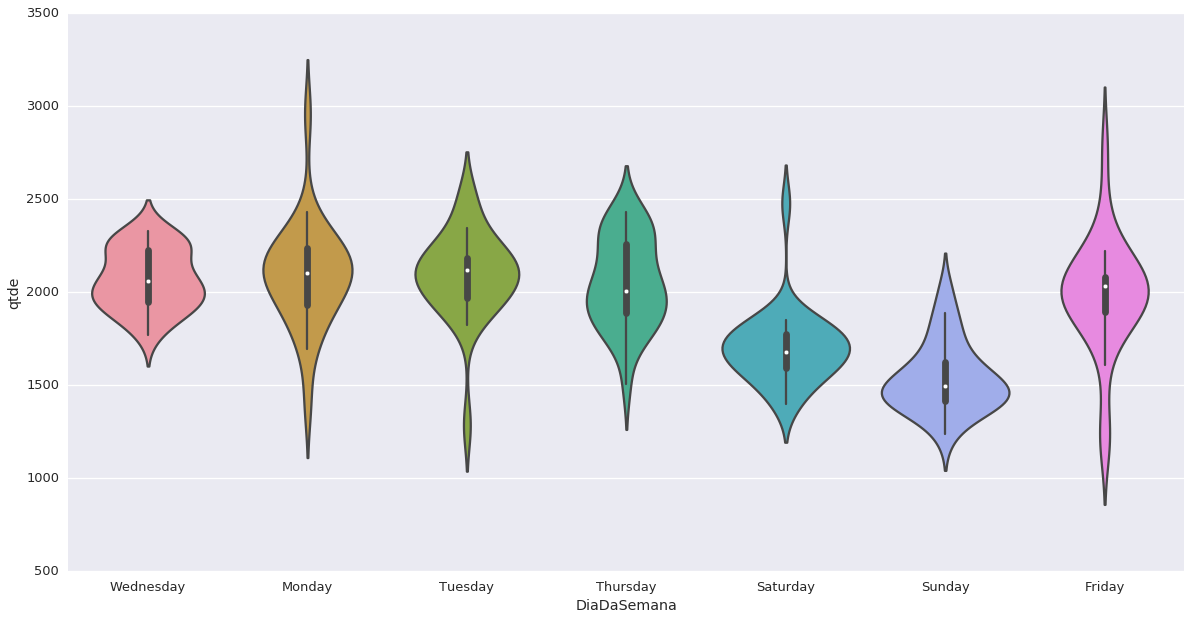

In [95]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="DiaDaSemana", y="qtde", data=dfCountContestacoesPorDiaPandas)

**Verificando a variância por semana do mês:**

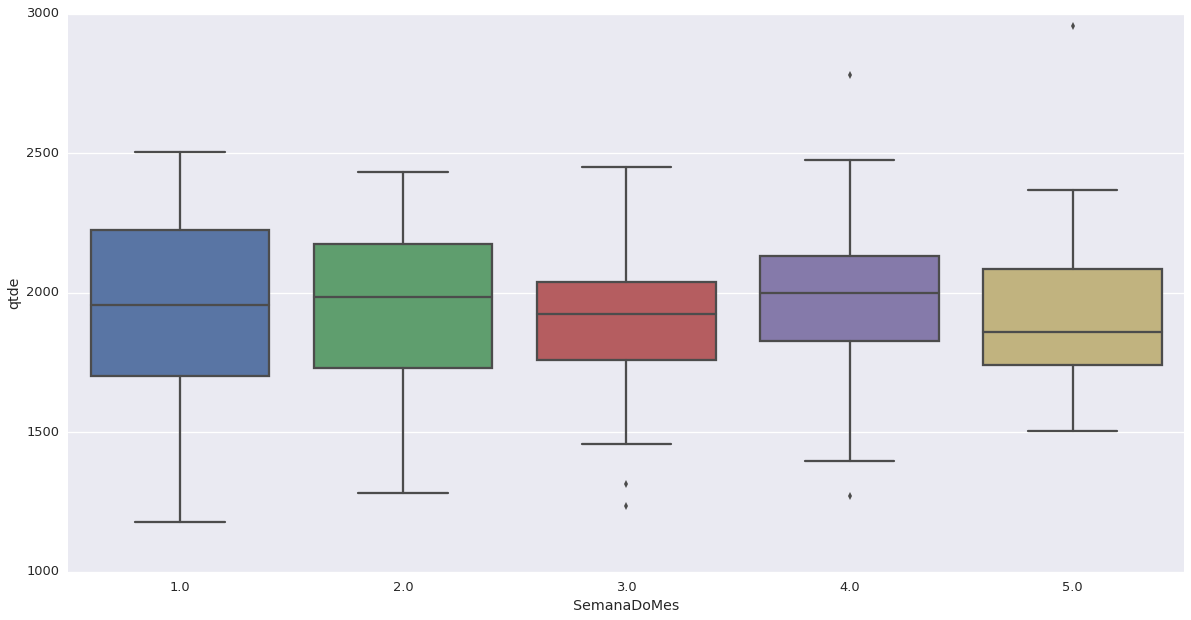

In [88]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="SemanaDoMes", y="qtde", data=dfCountContestacoesPorDiaPandas)

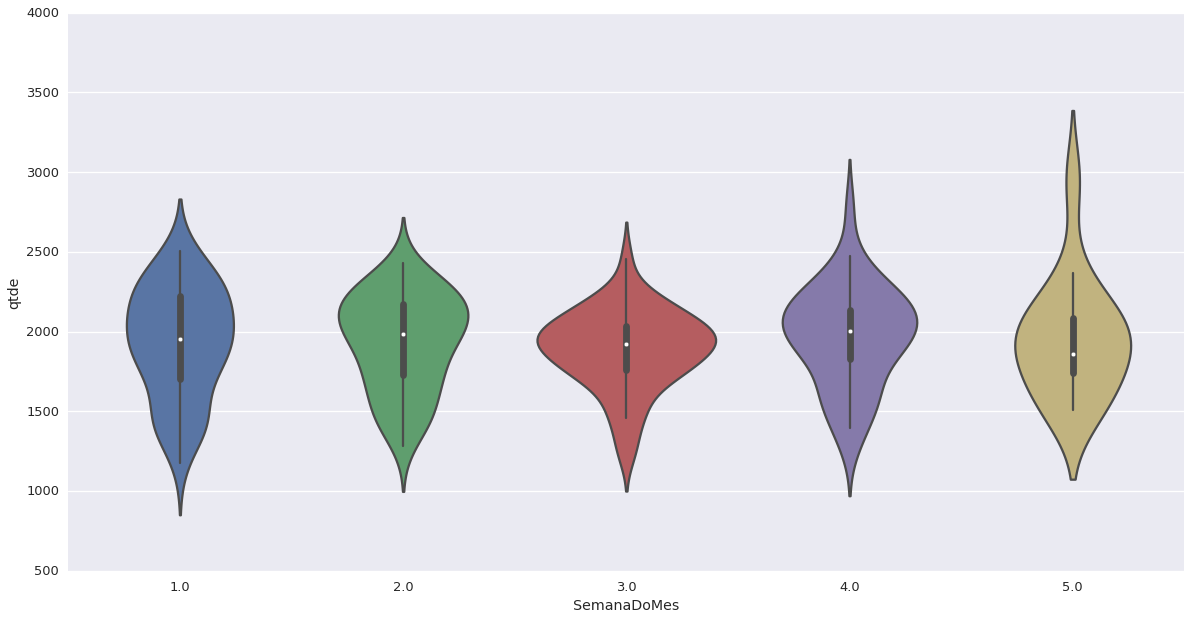

In [96]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="SemanaDoMes", y="qtde", data=dfCountContestacoesPorDiaPandas)

### Incluindo o modo de entrada na análise das variâncias

**Verificando a variância por dia da semana e modo de entrada digitado:**

In [15]:
dfCountContestacoesPorDiaEModoEntradaPandas = dfContestacoesData.groupBy('dataAutorizacao',
    'DiaDaSemana','SemanaDoMes','modoEntradaNome').count().select(col('dataAutorizacao'),
    col('DiaDaSemana'),col('SemanaDoMes'),col('modoEntradaNome'),col('count').alias('qtde')).cache()

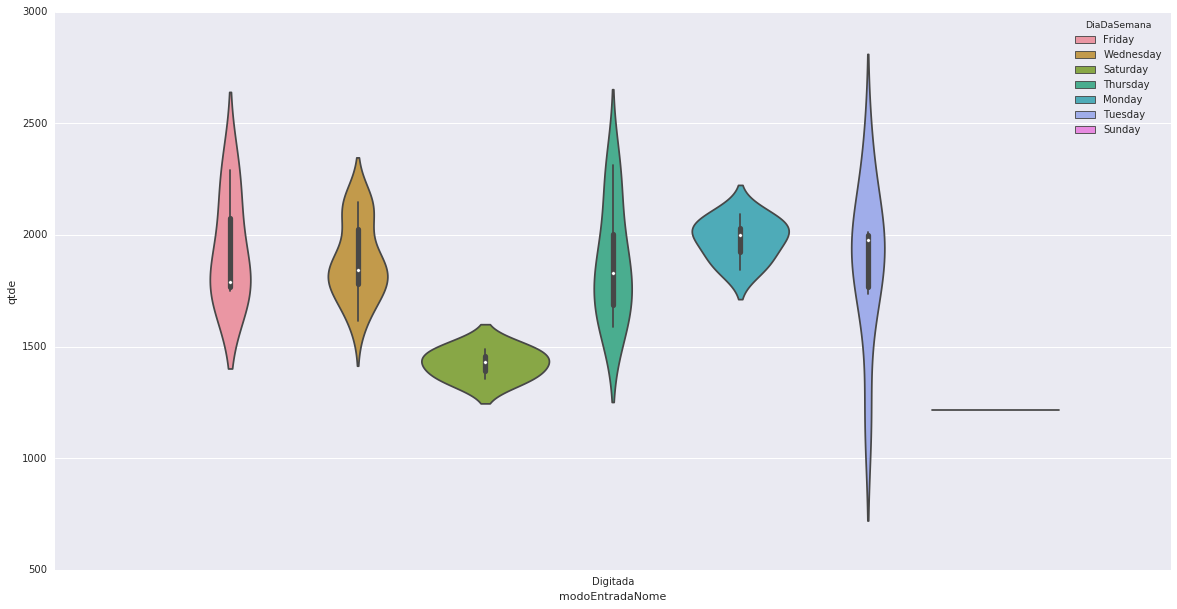

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="modoEntradaNome",hue="DiaDaSemana", y="qtde", 
                 data=dfCountContestacoesPorDiaEModoEntradaPandas.filter('modoEntradaNome = "Digitada"').toPandas())

**Verificando a variância por semana do mês e modo de entrada digitado:**

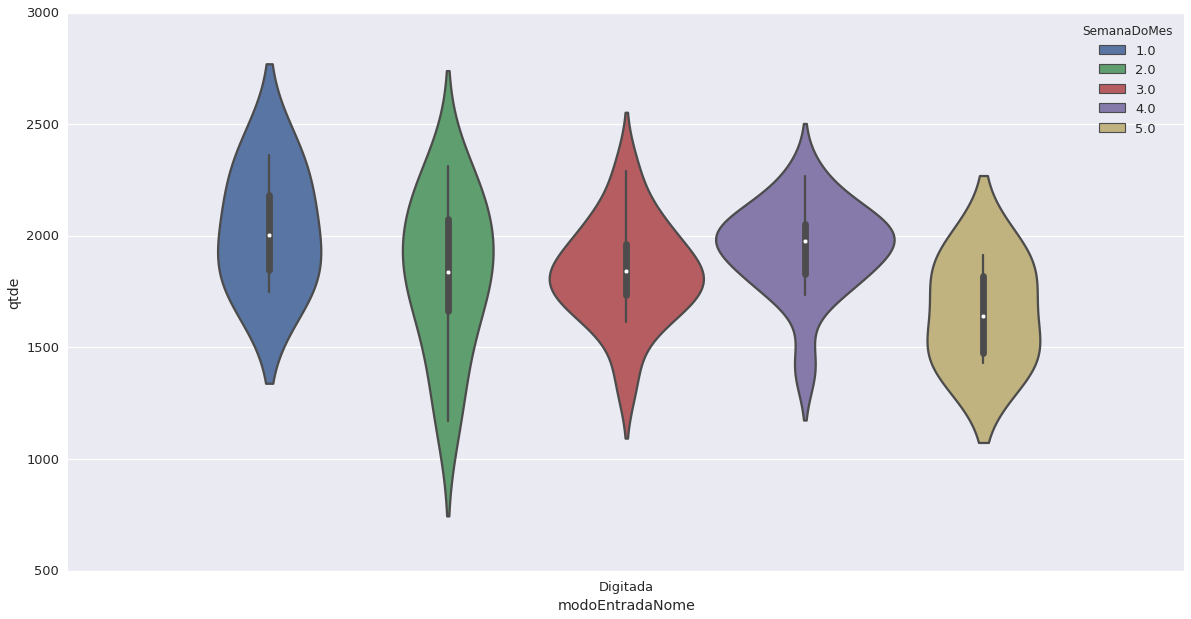

In [93]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="modoEntradaNome",hue="SemanaDoMes", y="qtde", 
                 data=dfCountContestacoesPorDiaEModoEntradaPandas.filter('modoEntradaNome = "Digitada"').toPandas())

**Verificando a variância por dia da semana e modo de entrada presente:**

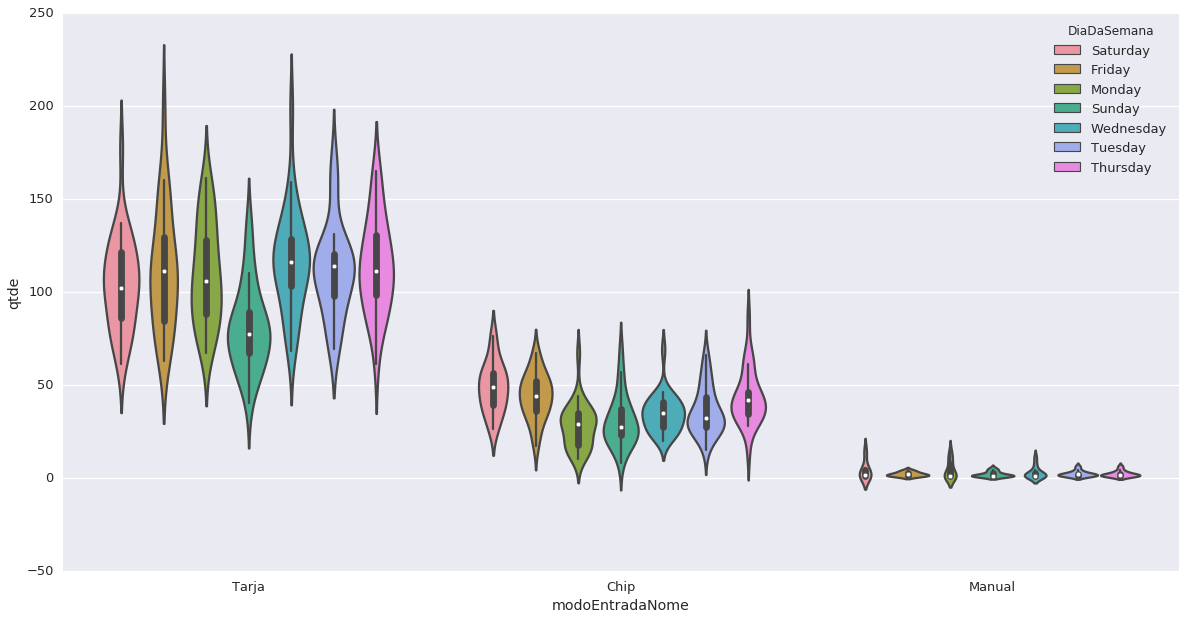

In [101]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="modoEntradaNome",hue="DiaDaSemana", y="qtde", 
  data=dfCountContestacoesPorDiaEModoEntradaPandas.filter('(modoEntradaNome != "Digitada") and (modoEntradaNome != "NÃO ENCONTRADO")').toPandas())

**Verificando a variância por semana do mês e modo de entrada presente:**

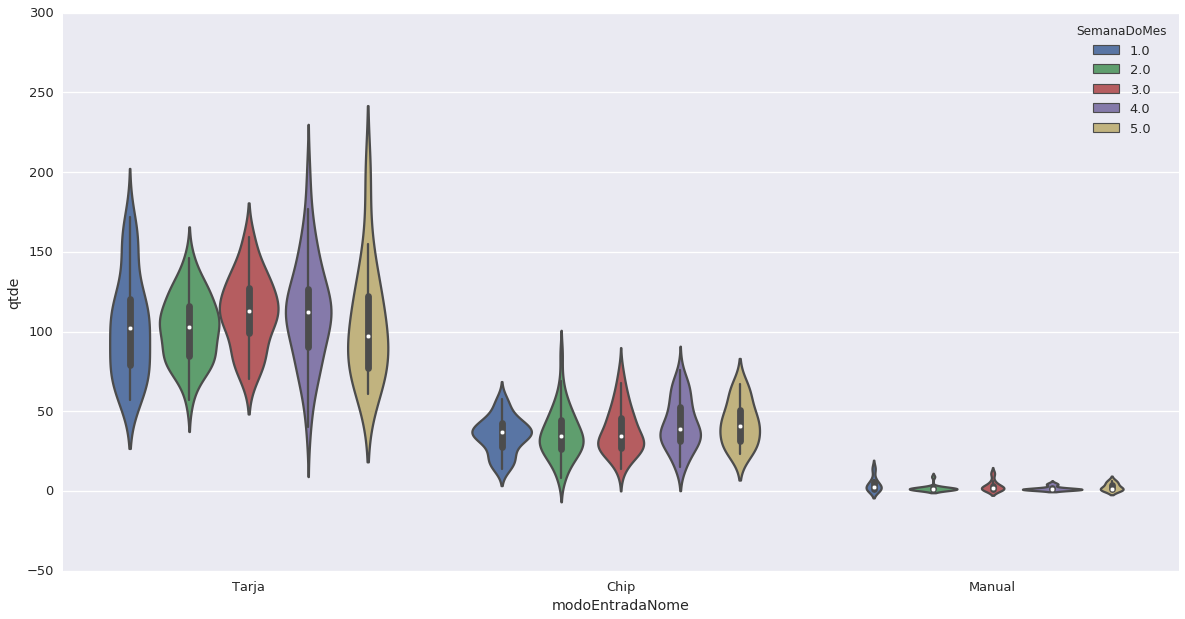

In [102]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="modoEntradaNome",hue="SemanaDoMes", y="qtde", 
  data=dfCountContestacoesPorDiaEModoEntradaPandas.filter('(modoEntradaNome != "Digitada") and (modoEntradaNome != "NÃO ENCONTRADO")').toPandas())

Quantidade de contestações ao longo do tempo por **modo de entrada:**

In [98]:
pandasDFPorModoEntradaEDia = dfContestacoesData.groupBy('dataAutorizacao',
                                                        'modoEntradaNome').count().select(col('dataAutorizacao'),
                                                  col('modoEntradaNome'),col('count').alias('qtde')).toPandas()
#pd.DataFrame(dfCountContestacoesDatapandas[['dataAutorizacao','modoEntradaNome']].groupby(['dataAutorizacao','modoEntradaNome']).size())

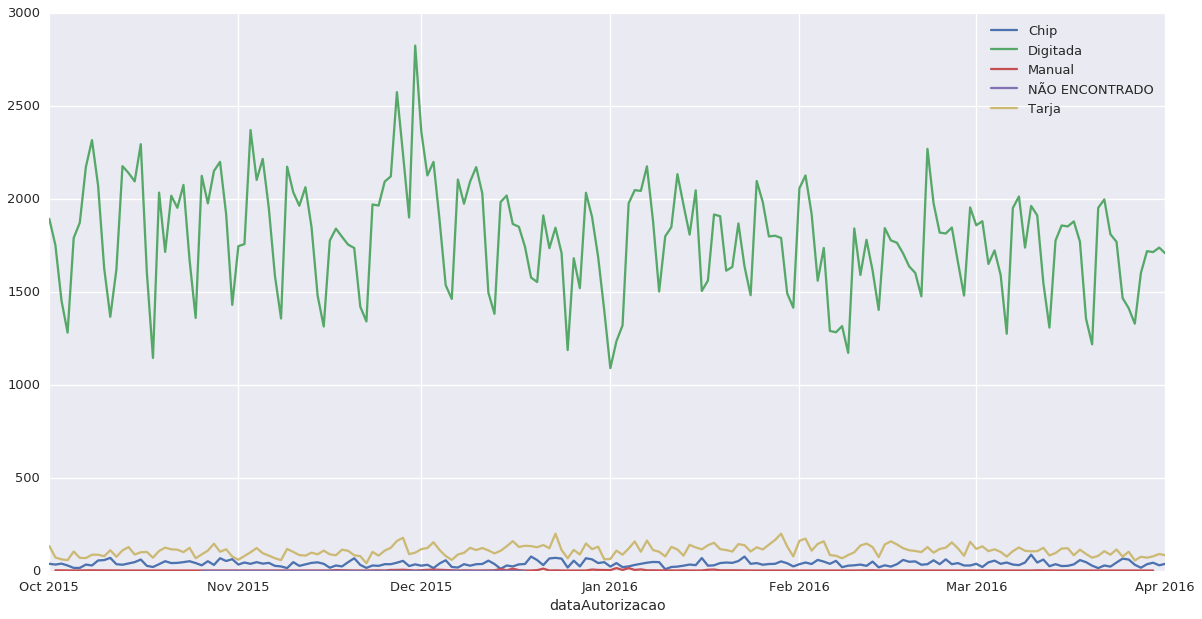

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
labels = []
for key, grp in pandasDFPorModoEntradaEDia.groupby(['modoEntradaNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

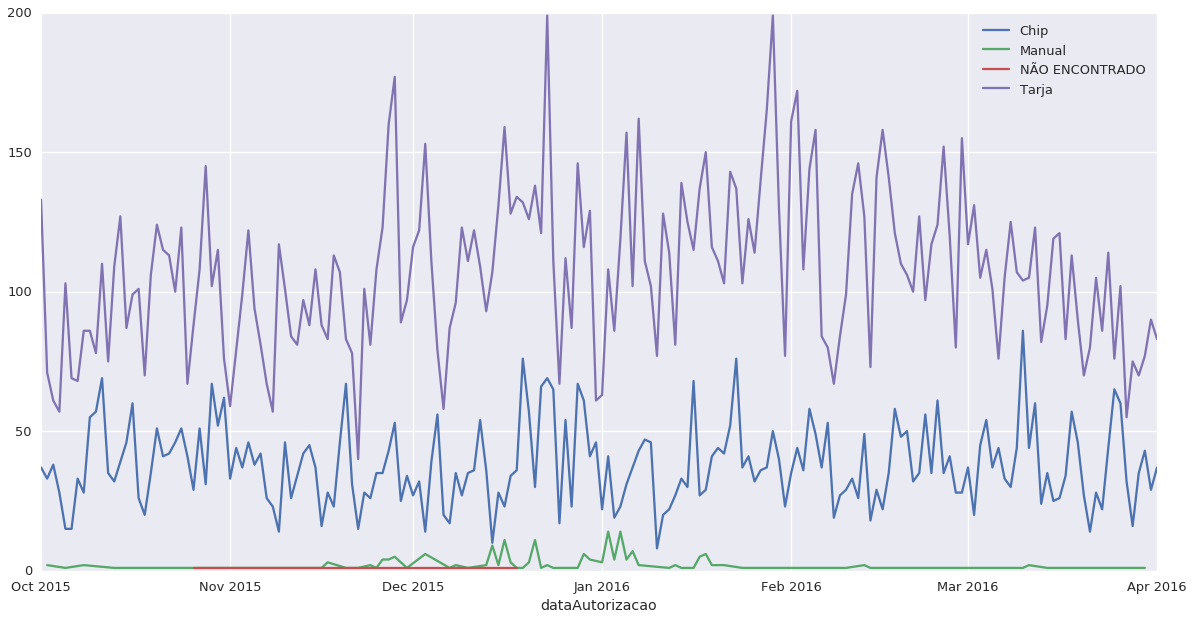

In [25]:
pandasDFPorModoEntradaEDiaSemDigitada = pandasDFPorModoEntradaEDia[pandasDFPorModoEntradaEDia['modoEntradaNome'] != 'Digitada']

fig, ax = plt.subplots(figsize=(20,10))
labels = []
for key, grp in pandasDFPorModoEntradaEDiaSemDigitada.groupby(['modoEntradaNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **modo de entrada - STACKED**:

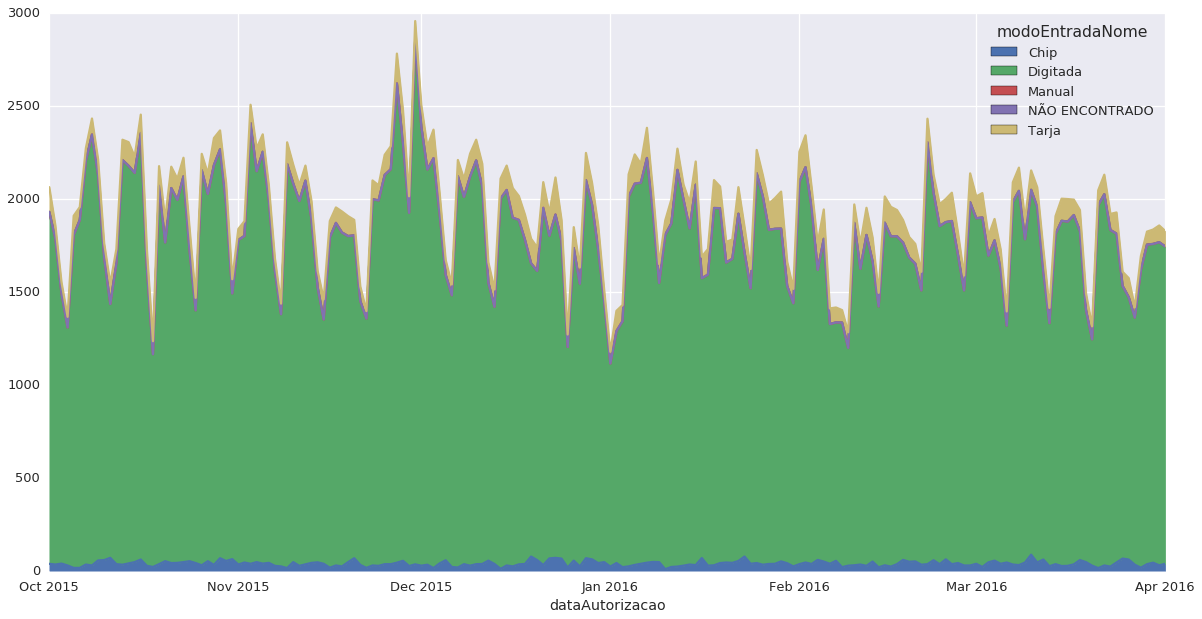

In [26]:
pandasDFPorModoEntradaEDia.groupby(['dataAutorizacao','modoEntradaNome']).qtde.sum().unstack('modoEntradaNome').fillna(0).plot.area(figsize=(20,10))
#pandasContestDiaModoEntrada.set_index('dataAutorizacao').plot()

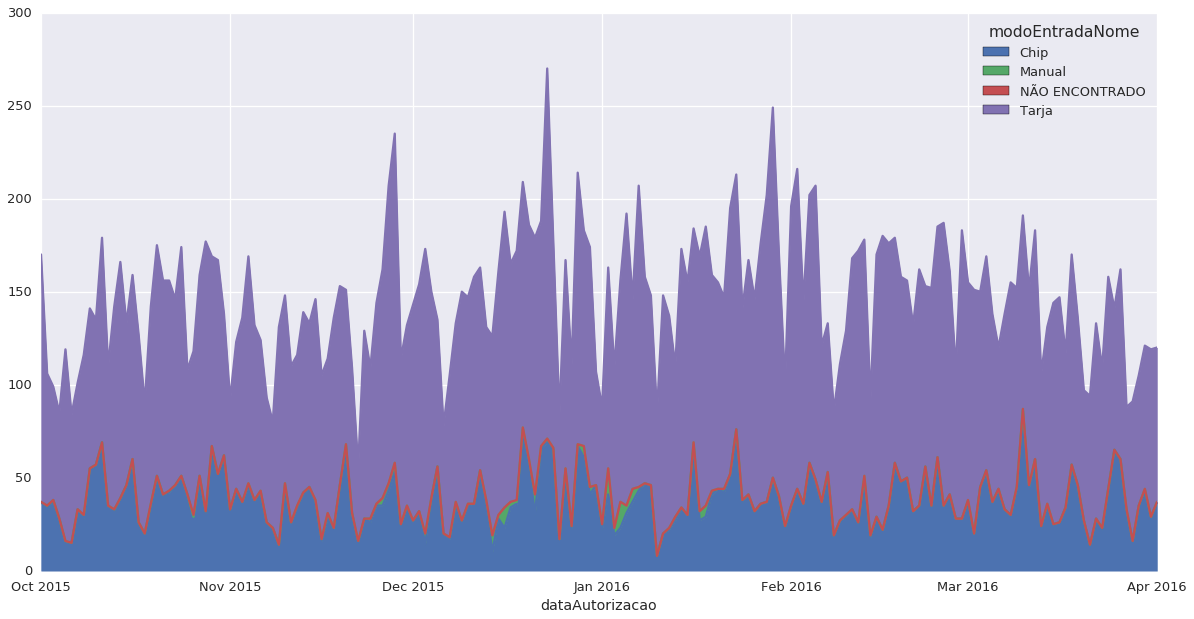

In [27]:
pandasDFPorModoEntradaEDia[pandasDFPorModoEntradaEDia['modoEntradaNome'] != 'Digitada'].groupby(['dataAutorizacao','modoEntradaNome']).qtde.sum().unstack('modoEntradaNome').fillna(0).plot.area(figsize=(20,10))

Quantidade de contestações ao longo do tempo por **modo de entrada - Presente Não Presente:**

Quantidade de contestações ao longo do tempo por **modo de entrada - Presente Não Presente - STACKED**:

Quantidade de contestações ao longo do tempo por **ramo de estabelecimento:**

In [103]:
pandasDFPorRamoEstabelecimentoEDia = dfContestacoesData.groupBy('dataAutorizacao',
  'ramoEstabelecimentoNome').count().select(col('dataAutorizacao'),
  col('ramoEstabelecimentoNome'),
  col('count').alias('qtde')).filter('(ramoEstabelecimentoNome = "SERVIÇOS") or (ramoEstabelecimentoNome = "MO TO") or (ramoEstabelecimentoNome = "ARTIGOS ELETRÔNICOS") or (ramoEstabelecimentoNome = "VAREJO")').toPandas()

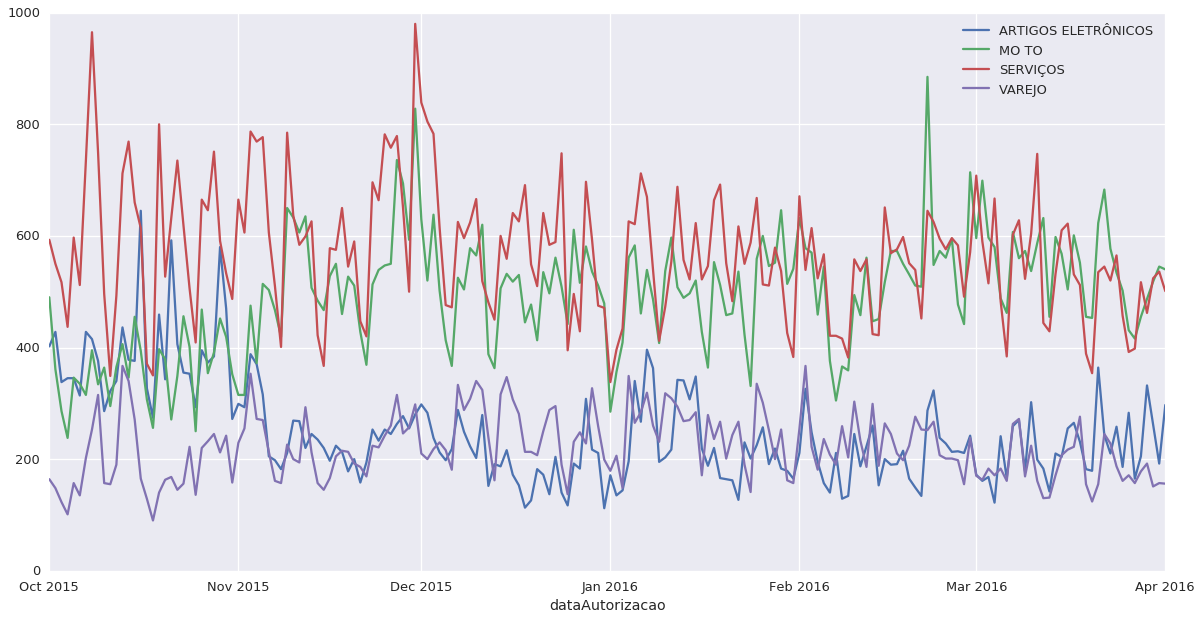

In [104]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.set_color_cycle(sns.color_palette("Set2",21))
labels = []
for key, grp in pandasDFPorRamoEstabelecimentoEDia.groupby(['ramoEstabelecimentoNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **ramo de estabelecimento - STACKED:**

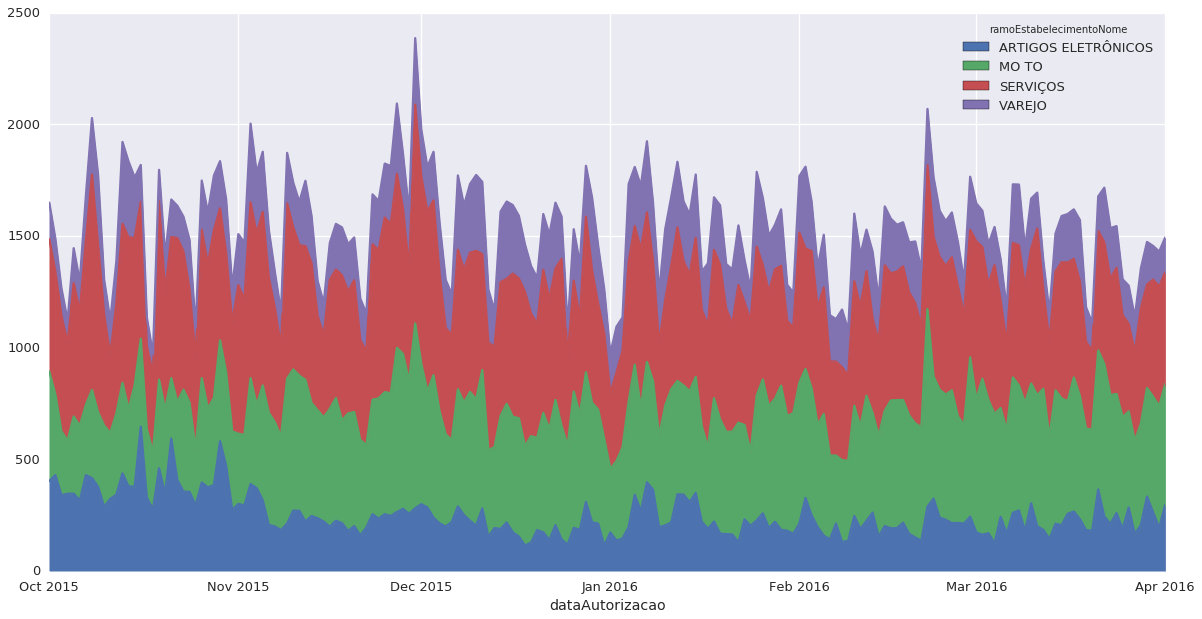

In [105]:
pandasDFPorRamoEstabelecimentoEDia.groupby(['dataAutorizacao',
                                            'ramoEstabelecimentoNome']).qtde.sum().unstack('ramoEstabelecimentoNome').fillna(0).plot.area(figsize=(20,10))


Quantidade de contestações ao longo do tempo por **país:**

In [106]:
dfContestacoesComPais = dfContestacoesData.withColumn('pais',
                                                      when(dfContestacoes.pais == 32,"Argentina").
                                                      when(dfContestacoes.pais == 76,"Brasil").
                                                      when(dfContestacoes.pais == 250,"França").
                                                      when(dfContestacoes.pais == 600,"Paraguai").
                                                      when(dfContestacoes.pais == 604,"Peru").
                                                      when(dfContestacoes.pais == 840,"USA").
                                                      when(dfContestacoes.pais == 826,"Inglaterra").
                                                      otherwise("Outros"))
dfContestacoesPorPais = dfContestacoesComPais.groupBy('dataAutorizacao','pais').count().select(col('dataAutorizacao'),
                                                                    col('pais'),col('count').alias('qtde')).toPandas()

# Sem utilização ainda
dfContestacoesComPaisEPorUsoPresente = dfContestacoesComPais.filter("usoPresente = 'Presente'")

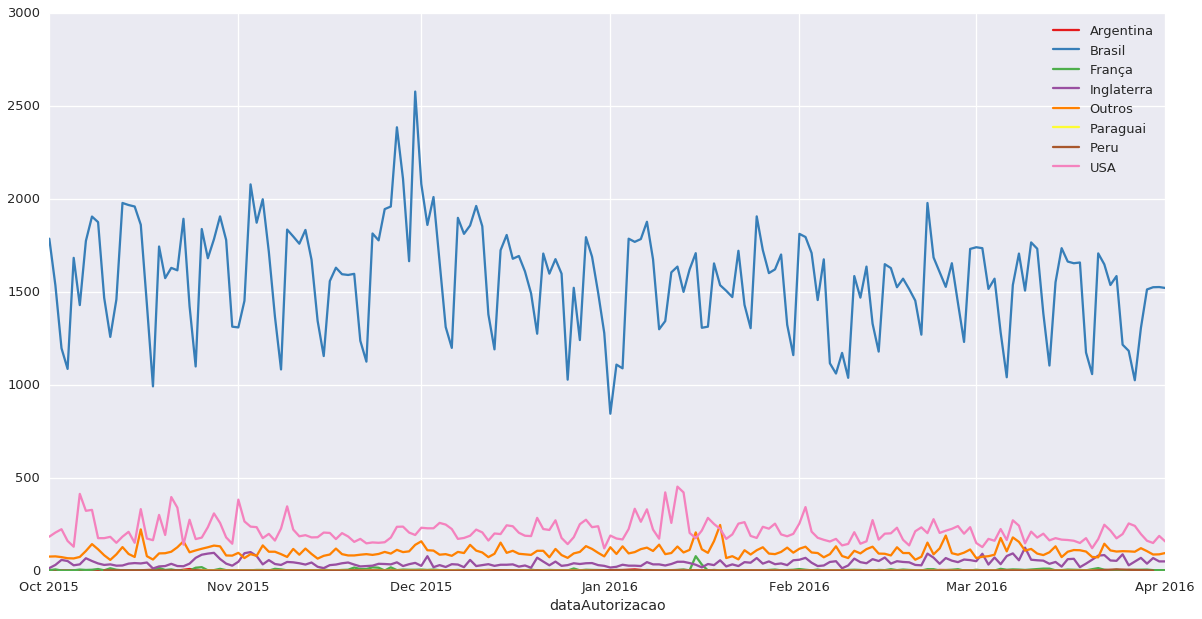

In [107]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_color_cycle(sns.color_palette("Set1",21))
labels = []
for key, grp in dfContestacoesPorPais.groupby(['pais']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **país - STACKED:**

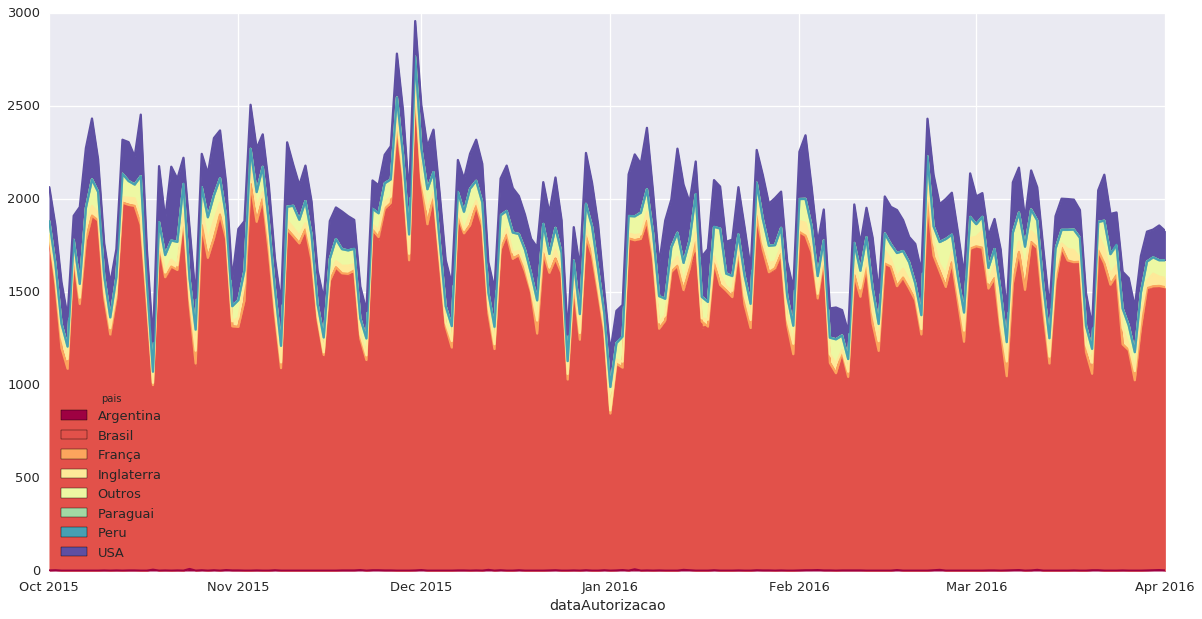

In [108]:
import matplotlib.pyplot as plt
sns.color_palette("Set1",21)
dfContestacoesPorPais.groupby(['dataAutorizacao','pais']).qtde.sum().unstack('pais').fillna(0).plot.area(figsize=(20,10),colormap='Spectral')